### TODO:

- Gradient checks (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html)
- Hyper-parameter tuning (https://scikit-learn.org/stable/modules/grid_search.html)
- L2 Regularization on Weights (2 hidden, 128 units, ReLu)
- You can report your findings either in the form of a table or a plot in the write-up. 
   Include in your colab notebook plots of the testing and training accuracy of the MLPs/ConvNet as a function of training epochs. 
   This will allow you to see how much the network should be trained before it starts to overfit to the training data.
- Creativity:
    - Effect of width (number of hidden units)
    - Effects of convolution hyper-parameter tuning on PyTorch ConvNet (number of filters, filter size, stride, padding)
    - Train with 10^k , k ∈ {0, 1, 2, 3, 4} images
    - Implement ConvNet (HARD)
- Note 2: We expect you to provide plots/tables in your report that justifies your choice of hyperparameters (the learning rates of the MLPs/ConvNets in parts 1-6, the architectural parameters of the MLPs/ConvNets in parts 5 & 6). You are not required to perform cross- validation in this assignment.

# Image Classification Using ConvNets

We will implement a Convolutional Neural Net from scratch to perform image classification. Many proven implementations of this ML model already exist and are available through free libraries such as tensorflow, pytorch etc. However we will not rely on these and instead build our own, to improve our understanding of what really is happening inside of the black box.

### Dataset

We will be working with [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist): a dataset containing 28x28 grayscale images of clothing articles. Although having the same type of input and range of labels, Fashion-MNIST is an alternative which is more challenging and better yet: more representative of modern image recognition problems; compared to the classic [MNIST](https://en.wikipedia.org/wiki/MNIST_database) we all know and love.

To download the dataset:

In [ ]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -P data
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -P data
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -P data
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -P data

After doing this, make sure to unzip the tarballs in order

### Imports

In [1]:
import matplotlib.pyplot as plt
import mnist
import numpy as np
import time
import torch
from typing import List
from tqdm import tqdm

## Understanding the data

In [2]:
mndata = mnist.MNIST('data')

images_train, labels_train = mndata.load_training()
images_test, labels_test = mndata.load_testing()

In [3]:
X_train_raw = np.array(images_train, dtype=np.float64)
X_test_raw = np.array(images_test, dtype=np.float64)
Y_train_raw = np.array(labels_train, dtype=np.uint8)
Y_test_raw = np.array(labels_test, dtype=np.uint8)

In [4]:
print(X_train_raw.shape, X_train_raw.dtype)
print(Y_train_raw.shape, Y_train_raw.dtype)
print(X_test_raw.shape)
print(Y_test_raw.shape)

(60000, 784) float64
(60000,) uint8
(10000, 784)
(10000,)


We have 60000 training examples and 10000 testing examples. Each of these is a list of 784 numbers which represent each of the 28x28 pixels in the image. The value of the number represents how black the pixel is.

In [5]:
label_to_article_map= {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

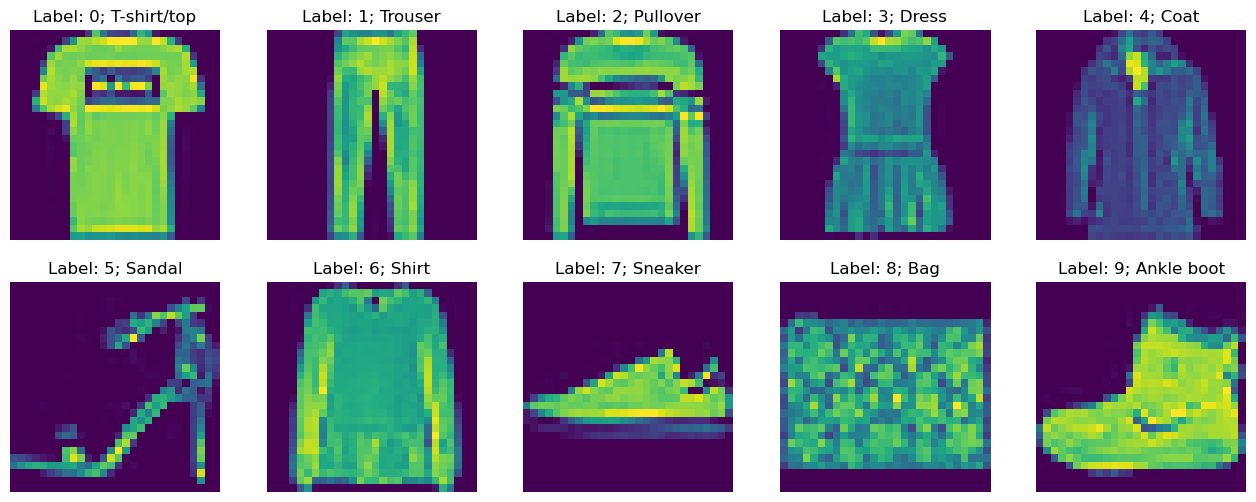

In [6]:
fig = plt.figure(figsize=(16,6))
rows = 2
columns = 5


for label in range(10):
    for n in range(len(X_train_raw)):
        if Y_train_raw[n] == label:
            fig.add_subplot(rows, columns, Y_train_raw[n] + 1)
            
            image = X_train_raw[n]
            label = Y_train_raw[n]

            image = np.array(image, dtype='float')
            pixels = image.reshape((28, 28))
            plt.imshow(pixels)
            plt.axis('off')
            plt.title(f"Label: {Y_train_raw[n]}; {label_to_article_map[Y_train_raw[n]]}")
            break

### Standardization

We will now standardize the data by pulling the mean to the center and adjusting the scale.

In [7]:
print(np.mean(X_test_raw))
print(np.mean(X_train_raw))

73.14656658163265
72.94035223214286


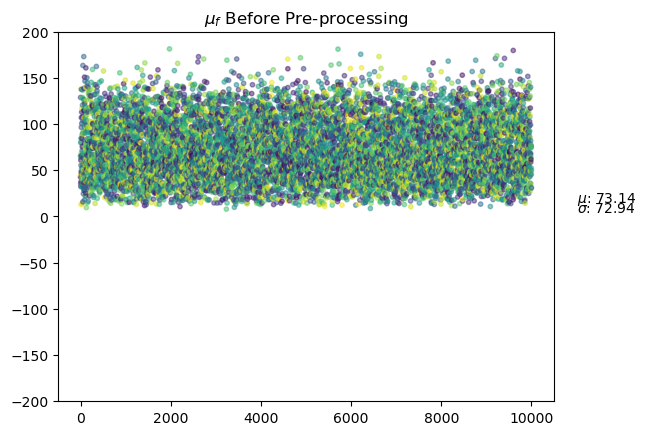

In [8]:
plt.scatter(np.arange(0, len(X_test_raw)), list(map(np.mean, X_test_raw)),  s=10,  alpha=.5, c = np.random.rand(X_test_raw.shape[0]))
plt.title(r"$\mu_f$ Before Pre-processing")
plt.text(11000, 15, r"$\mu$: 73.14")
plt.text(11000, 4, r"$\sigma$: 72.94")
plt.ylim(-200, 200)
plt.show()

In [9]:
# Centering
X_train = X_train_raw - np.mean(X_train_raw, axis=0)
X_test = X_test_raw - np.mean(X_test_raw, axis=0)

# Normalization
X_train = X_train / np.std(X_train_raw, axis = 0)
X_test = X_test / np.std(X_test_raw, axis = 0)

Y_train = Y_train_raw
Y_test = Y_test_raw

In [10]:
print(f"Mean X_train: {np.mean(X_train)}")
print(f"Mean X_test: {np.mean(X_test)}")
print()
print(f"Std X_train: {np.std(X_train)}")
print(f"Std X_test: {np.std(X_test)}")


Mean X_train: -1.8899470046408106e-18
Mean X_test: -1.522591576628786e-18

Std X_train: 1.000000000000002
Std X_test: 0.9999999999999976


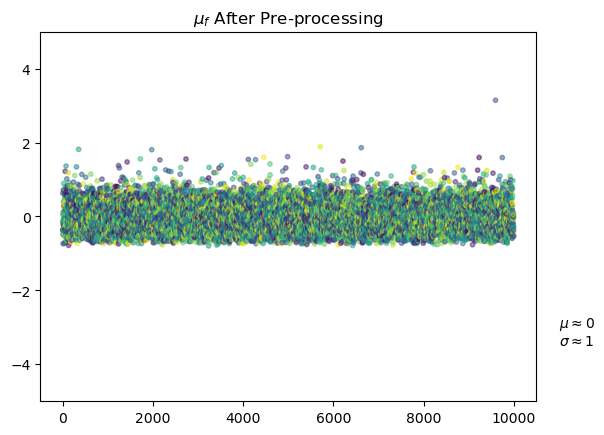

In [11]:
plt.scatter(np.arange(0, len(X_test)), list(map(np.mean, X_test)),  s=10,  alpha=.5, c = np.random.rand(X_test.shape[0]))
plt.title(r"$\mu_f$ After Pre-processing")
plt.text(11000, -3, r"$\mu \approx 0$")
plt.text(11000, -3.5, r"$\sigma \approx 1$")
plt.ylim(-5, 5)
plt.show()

We've effectively reduced the mean to 0 and the standard deviation to 1, completing the pre-processing stage.

## Multi-Layer Perceptron Implementation

Here we define a base class for one layer of our multi-layered perceptron.

### Neural Net Layers

Each layer implements two types of methods:
<ol>
    <li>forward(x): Process x using the activation function and return the result.
    </li>
    <li>backward(gradient): Take gradient calculated at the next layers, compute and return gradient at this layer.
    </li>
</ol>

And has two attributes:
<ol>
    <li>parameters: List of parameters (weight and bias).
    </li>
    <li>gradient: The gradient of the current layer.
    </li>
</ol>

In [12]:
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None

        #self.regularization decides if the weights in this layer will be regularized.
        #By default, this is boolean False, meaning no special regularization will be carried out.
        #But we may change it to a positive float, which will serve as the constant used in regularization.
        self.regularization = False
        
    def forward(self, x):
        raise NotImplementedError
        
    def backward(self, gradient):
        raise NotImplementedError

We define the layers that implement this class, which are Linear, ReLu and Softmax. Note that although they all inherit from the same base class, they're vastly different.

- Linear layer simply applies the weight and bias to pass the input forwards.
- ReLu is our activation function.
- Softmax is our output function.

## TODO: Gradient Checks

In [13]:
class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size, parameter_variance):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        np.random.seed(42)
        self.weights = np.random.randn(output_size, input_size) * parameter_variance
        # randn samples from N(0,1), we want a lower variance to avoid underflow in softmax
        
        np.random.seed(42) # the seed is consumed each time
        self.bias = np.random.randn(output_size) * parameter_variance
        
        self.parameters = [self.weights, self.bias]
        self.cur_input = None
        
    def forward(self, x):
        self.cur_input = x
        return (self.weights[None, :, :] @ x[:, :, None]).squeeze() + self.bias
    
    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before calling backward!"
        dw = gradient[:, :, None] @ self.cur_input[:, None, :]
        db = gradient
        self.gradient = [dw, db]
        return gradient.dot(self.weights)


In [14]:
class ReLuLayer(NeuralNetLayer):
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before calling backward!"
        return gradient * self.gradient

In [15]:
class SoftMaxLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None
        
    def forward(self, x):
        copy = np.array(x, copy = True, dtype = np.float64)
        maximum = np.max(copy, axis=-1)[:, None]
        copy = copy - maximum # avoid overflow, result will be the same as -max()'s cancel out
        exps = np.exp(copy)

        exps[exps < 10**(-100)] = 10**(-100)
        exps[exps > 10**(100)] = 10**(100)
        
        probs = exps / np.sum(exps, axis=-1)[:, None]
        self.cur_probs = probs
        return probs
    
    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before calling backward!"
        return self.cur_probs - target

### MLP Class

In [16]:
class MLP:
    def __init__(self, *args: List[NeuralNetLayer]):
        self.layers = args
        
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)

### Stochastic Gradient Descent with Batching

<ol>
    <li> During training, we choose a random subset (batch) of our data to use in our gradient calculation.
    <li> When we update the weights, we subtract the <strong>mean of our gradient</strong> times the learning rate. 
        <ul>
            <li> In contrast to regular gradient descent where we subtract the gradient itself.</li>
        </ul>
    <li> Then we do this again. Note that we decay the change in weights as epochs increase.
</ol>

In [17]:
class SGDOptimizer:
    def __init__(self, net: MLP, lr: float):
        self.net = net
        self.lr = lr

    def step(self, epoch):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient, epoch, regularization = layer.regularization)

    def update(self, params, gradient, epoch, regularization):
        if regularization == False:
            for (p, g) in zip(params, gradient):
                p -= self.lr * g.mean(axis=0) / (epoch+1)
        else:
            for (p, g) in zip(params, gradient):
                p = (1-self.lr / (epoch+1) * regularization)*p - self.lr * g.mean(axis=0) / (epoch+1)


Note: mini-batching is used in fit.

In [18]:
def mini_batch(N,k):
    random_index_list = np.random.choice(N,N, replace= False)
    result = [list(random_index_list[x:x+k]) for x in range(0,N,k)]

    if len(result[-1]) != k:
        result.pop()

    return np.array(result)

### Fit & Predict

In [19]:
def fit(self, data_x, data_y, steps, batch_size, learning_rate):
    self.steps = steps
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.losses = []
    self.accuracies = []
    self.prediction_loss = 0
    self.prediction_acc = 0
    
    N = len(X_train)
    self.batches = mini_batch(N, self.batch_size)
    self.optimizer = SGDOptimizer(net = self, lr = self.learning_rate)
    
    labels = np.eye(np.max(data_y)+1)[np.array(data_y)]
    for epoch in tqdm(range(steps)):
        X = data_x[self.batches[epoch % len(self.batches)]]
        Y = labels[self.batches[epoch % len(self.batches)]]
        
        predictions = self.forward(X)
        
        if epoch % 10 == 0:
            self.losses.append(self.evaluate_loss(Y, predictions))
            self.accuracies.append(self.evaluate_acc(Y, predictions))
        
        self.backward(Y)
        self.optimizer.step(epoch)
        
MLP.fit = fit

In [20]:
def predict(self, data_x, data_y):
    C = np.max(data_y) + 1
    labels = np.eye(C)[np.array(data_y)]
    predictions = self.forward(data_x)
    
    self.prediction_loss = self.evaluate_loss(labels, predictions)
    self.prediction_acc = self.evaluate_acc(labels, predictions)
    
MLP.predict = predict

### Evaluation

We use accuracy and Cross-Entropy Loss to evaluate the performance of our model.

In [21]:
def evaluate_acc(self, y, y_hat):
    count = 0
    for i in range(len(y)):
        if np.argmax(y[i]) == np.argmax(y_hat[i]):
            count += 1
            
    return (count / len(y)) * 100

MLP.evaluate_acc = evaluate_acc

def evaluate_loss(self, y, y_hat):
    return -(y * np.log(y_hat)).sum(axis=-1).mean()

MLP.evaluate_loss = evaluate_loss

### Plot Helper

In [22]:
def plot(self):
    fig = plt.figure(figsize=(16,6))
    rows = 1
    columns = 2

    fig.add_subplot(rows, columns, 1)
    fig.suptitle("Training loss and accuracy", fontsize=20)
    if self.prediction_loss:
        plt.plot(len(self.losses), self.prediction_loss, color='red', marker='*', label=f"Test Loss: {self.prediction_loss:.3f}")
    plt.plot(self.losses, linewidth = .5, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.add_subplot(rows, columns, 2)
    plt.plot(self.accuracies, linewidth = .5, label="Training Accuracy")
    if self.prediction_acc:
        plt.plot(len(self.accuracies), self.prediction_acc, color='red', marker='*', label=f"Test Accuracy: {self.prediction_acc:.3f}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.show()
    
MLP.plot = plot

# Experiments

Now that the class is coded, we move on conducting experiments. For the duration of all our experiments, we fix the following quantities as <b>defaults</b>: the input/output dimensions, the number of iterations, the number of hidden units whenever there is a hidden layer, the learning rate, batch-sze and parameter (weight/bias) variance.

In [23]:
hidden_units = 128
gradient_steps = 2000
learning_rate = 5e-2

D = X_train.shape[1]
C = np.max(Y_train) + 1

batch_size = 30
parameter_variance = 0.1

## 1. Effect of Network Depth on Accuracy

Given our default configurations, we investigate how the depth of our neural network affects the results.

### 0 Hidden Layers (Linear + Softmax)

100%|██████████| 2000/2000 [00:02<00:00, 709.09it/s]


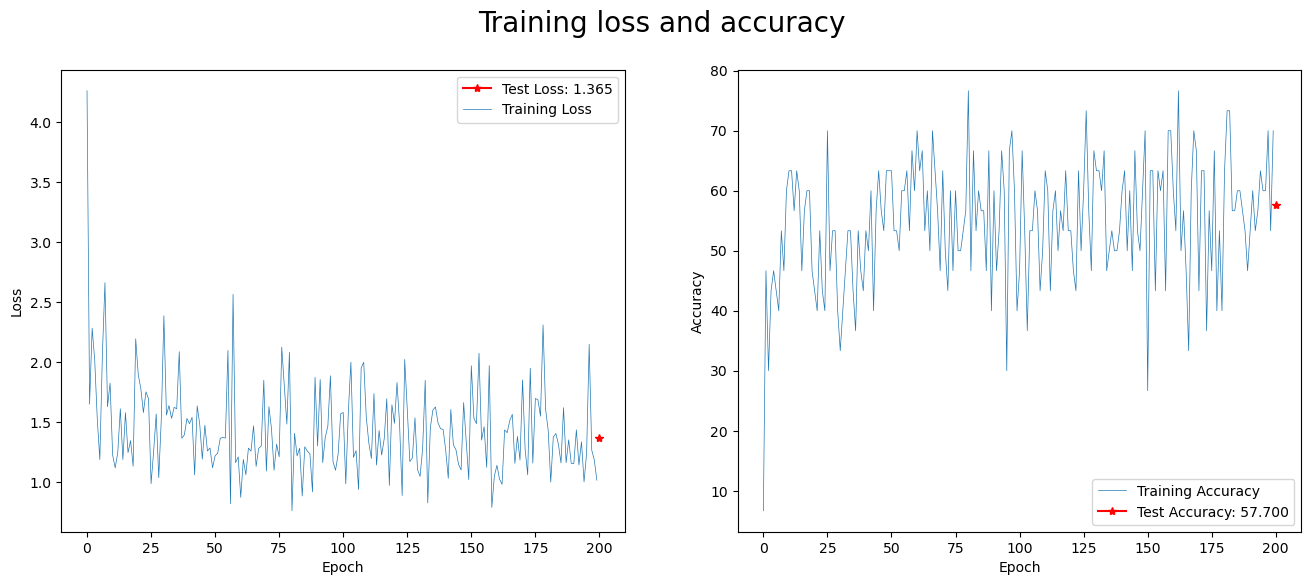

In [24]:
no_hidden = MLP(
    LinearLayer(D, C, parameter_variance),
    SoftMaxLayer(),
)

no_hidden.fit(data_x = X_train, data_y = Y_train, steps = gradient_steps,
         batch_size = batch_size, learning_rate = learning_rate)

no_hidden.predict(data_x = X_test, data_y = Y_test)
no_hidden.plot()

### 1 Hidden Layer, 128 Units, ReLu

100%|██████████| 2000/2000 [00:30<00:00, 66.16it/s]


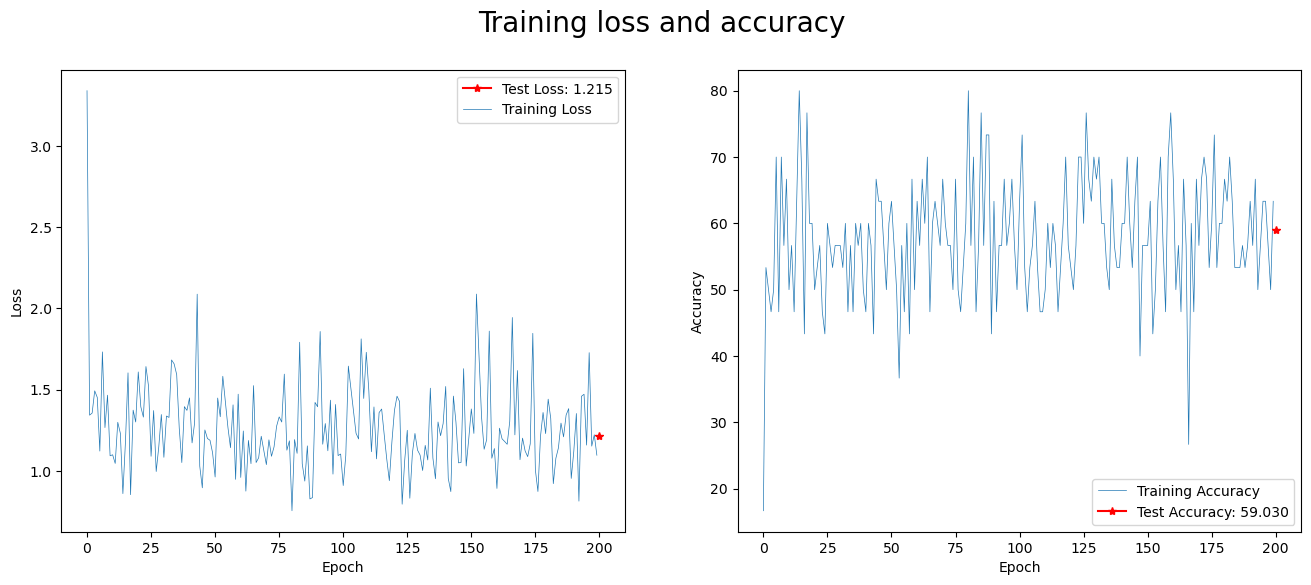

In [25]:
one_hidden = MLP(
    LinearLayer(D, hidden_units, parameter_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, C, parameter_variance),
    SoftMaxLayer(),

)
one_hidden.fit(data_x = X_train, data_y = Y_train, steps = gradient_steps,
         batch_size = batch_size, learning_rate = learning_rate)

one_hidden.predict(data_x = X_test, data_y = Y_test)
one_hidden.plot()

### 2 Hidden 128 Units

100%|██████████| 2000/2000 [00:35<00:00, 56.06it/s]


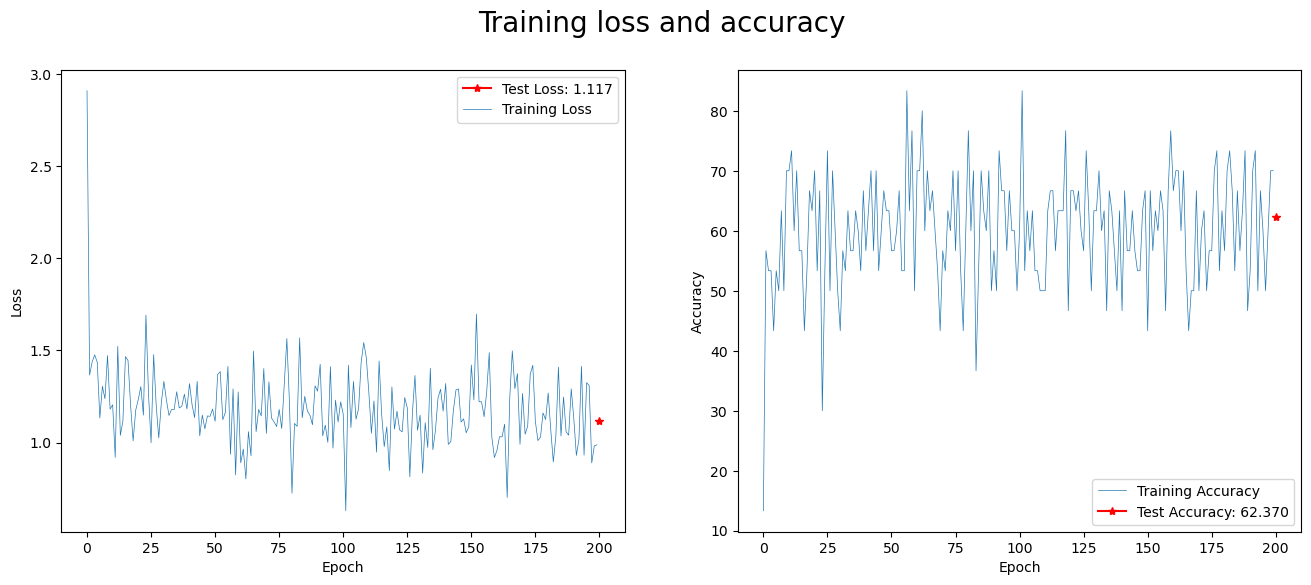

In [26]:
two_hidden = MLP(
    LinearLayer(D, hidden_units, parameter_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, hidden_units, parameter_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, C, parameter_variance),
    SoftMaxLayer(),

)
two_hidden.fit(data_x = X_train, data_y = Y_train, steps = gradient_steps,
         batch_size = batch_size, learning_rate = learning_rate)

two_hidden.predict(data_x = X_test, data_y = Y_test)
two_hidden.plot()

### 3 Hidden 128 Units

100%|██████████| 2000/2000 [00:42<00:00, 47.50it/s]


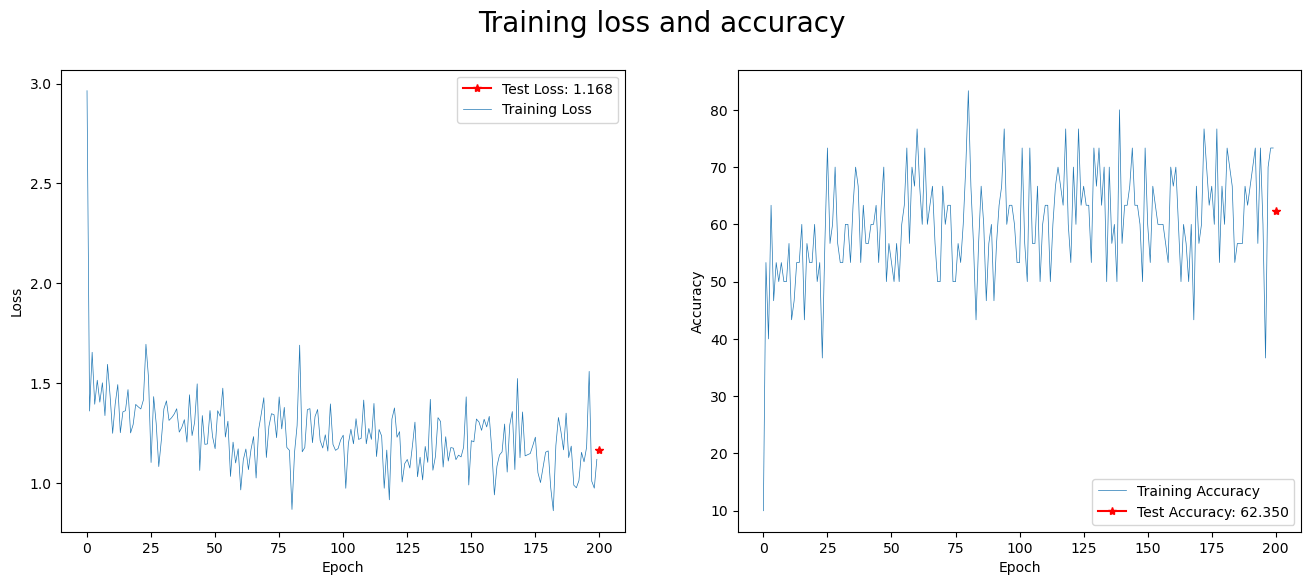

In [27]:
three_hidden = MLP(
    LinearLayer(D, hidden_units, parameter_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, hidden_units, parameter_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, hidden_units, parameter_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, C, parameter_variance),
    SoftMaxLayer(),

)
three_hidden.fit(data_x = X_train, data_y = Y_train, steps = gradient_steps,
         batch_size = batch_size, learning_rate = learning_rate)

three_hidden.predict(data_x = X_test, data_y = Y_test)
three_hidden.plot()

### 4 Hidden 128 Units

100%|██████████| 2000/2000 [00:47<00:00, 42.26it/s]


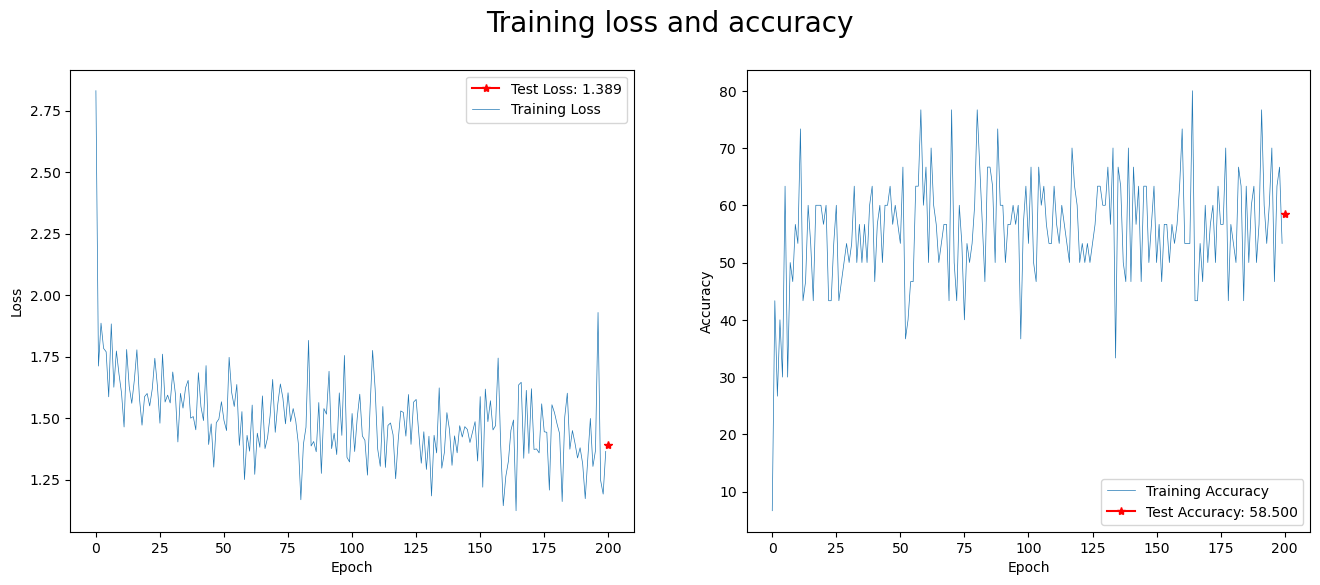

In [28]:
four_hidden = MLP(
    LinearLayer(D, hidden_units, parameter_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, hidden_units, parameter_variance),
    ReLuLayer(),

    LinearLayer(hidden_units, hidden_units, parameter_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, hidden_units, parameter_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, C, parameter_variance),
    SoftMaxLayer(),

)
four_hidden.fit(data_x = X_train, data_y = Y_train, steps = gradient_steps,
         batch_size = batch_size, learning_rate = learning_rate)

four_hidden.predict(data_x = X_test, data_y = Y_test)
four_hidden.plot()

### 5 Hidden Relu

100%|██████████| 2000/2000 [00:53<00:00, 37.54it/s]


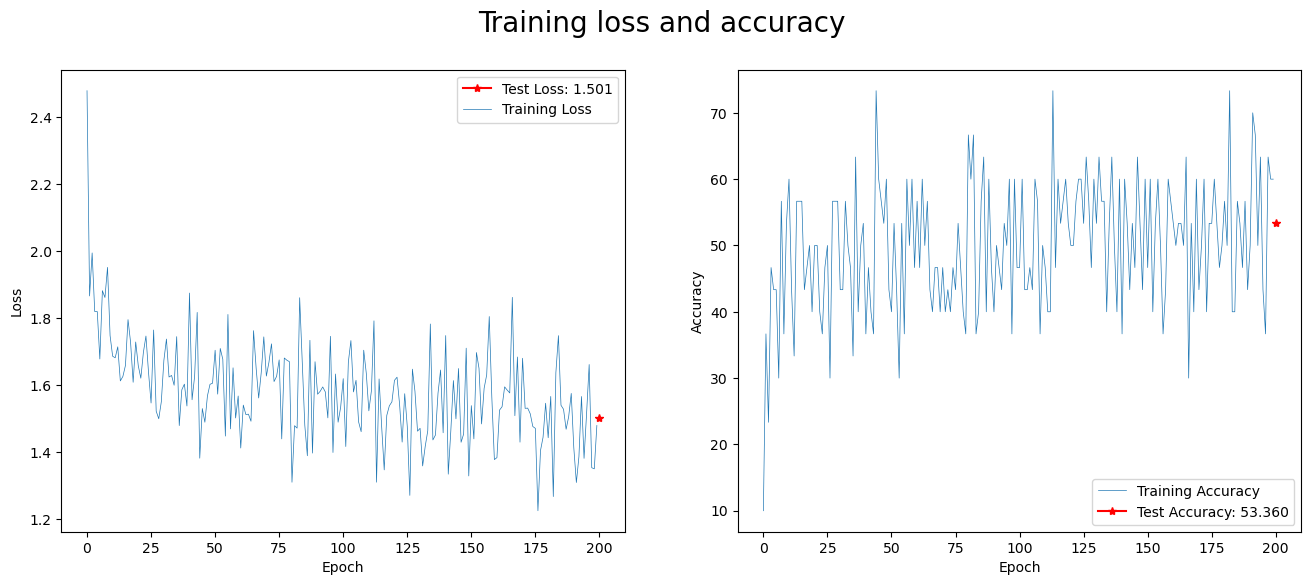

In [29]:
five_hidden = MLP(
    LinearLayer(D, hidden_units, parameter_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, hidden_units, parameter_variance),
    ReLuLayer(),

    LinearLayer(hidden_units, hidden_units, parameter_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, hidden_units, parameter_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, hidden_units, parameter_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, C, parameter_variance),
    SoftMaxLayer(),

)
five_hidden.fit(data_x = X_train, data_y = Y_train, steps = gradient_steps,
         batch_size = batch_size, learning_rate = learning_rate)

five_hidden.predict(data_x = X_test, data_y = Y_test)
five_hidden.plot()

We see a decrease in loss and an increase in accuracy as we increase the network depth up until a certain threshold. After this point we see a decrease in performance quite possibly due to overfitting.

## 2. Effect of Activation Function on Accuracy

We investigate how different activation functions affect our accuracy.

### ReLU

For ReLU performance, see the code in section 1.

### Leaky ReLu

Leaky ReLu is essentialy ReLu, which "leaks" a small portion of the negative values in its input determined by a scalar, which is usally between 0.01 - 0.1

In [30]:
class LeakyReLuLayer(NeuralNetLayer):
    def __init__(self, scalar):
        super().__init__()
        self.scalar = scalar
        
    def forward(self, x):
        self.gradient = np.where(x < 0, self.scalar, 1.0)
        return np.where(x < 0, x * self.scalar, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

For this section we will experiment with different scalars to see how it affects performance.

#### Leaky ReLu Scalar 0.02

100%|██████████| 2000/2000 [00:37<00:00, 52.71it/s]


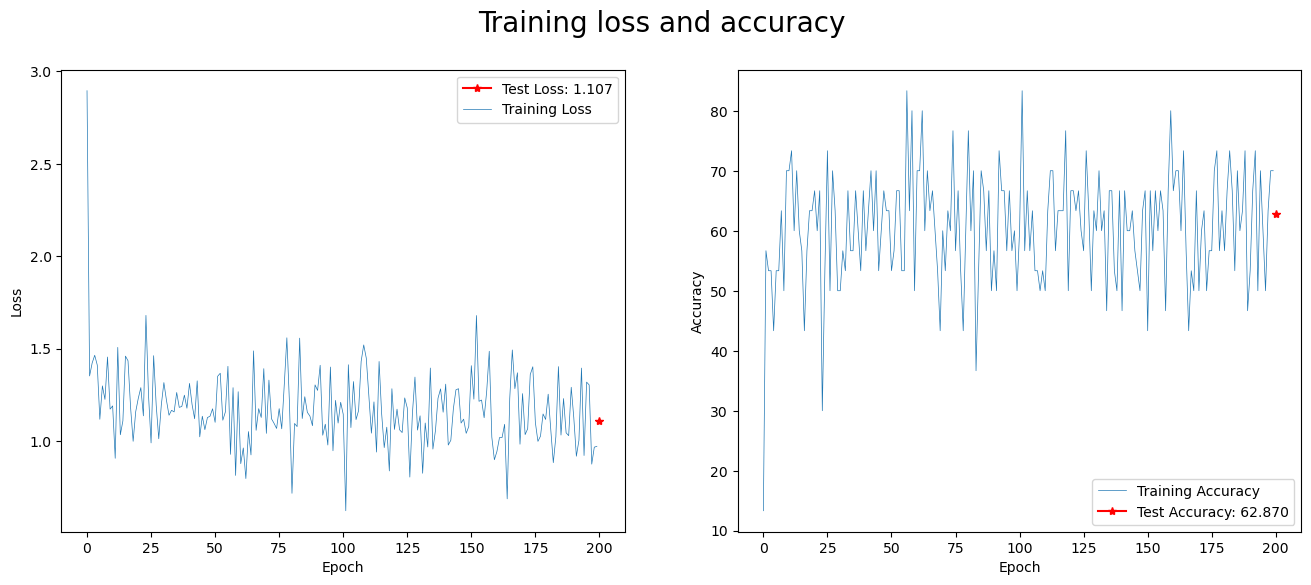

In [31]:
scalar = .02

leaky_002 = MLP(
    LinearLayer(D, hidden_units, parameter_variance),
    LeakyReLuLayer(scalar),
    
    LinearLayer(hidden_units, hidden_units, parameter_variance),
    LeakyReLuLayer(scalar),
    
    LinearLayer(hidden_units, C, parameter_variance),
    SoftMaxLayer(),

)
leaky_002.fit(data_x = X_train, data_y = Y_train, steps = gradient_steps,
         batch_size = batch_size, learning_rate = learning_rate)

leaky_002.predict(data_x = X_test, data_y = Y_test)
leaky_002.plot()

#### Leaky ReLu Scalar 0.2

100%|██████████| 2000/2000 [00:38<00:00, 52.09it/s]


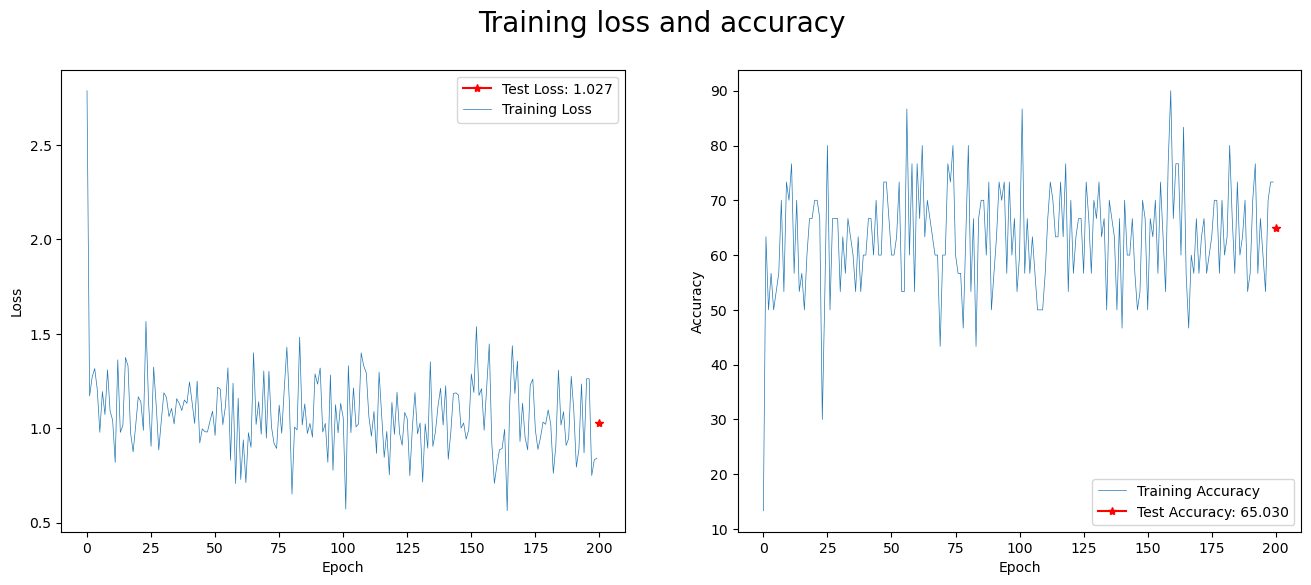

In [32]:
scalar = 0.2

leaky_020 = MLP(
    LinearLayer(D, hidden_units, parameter_variance),
    LeakyReLuLayer(scalar),
    
    LinearLayer(hidden_units, hidden_units, parameter_variance),
    LeakyReLuLayer(scalar),
    
    LinearLayer(hidden_units, C, parameter_variance),
    SoftMaxLayer(),

)
leaky_020.fit(data_x = X_train, data_y = Y_train, steps = gradient_steps,
         batch_size = batch_size, learning_rate = learning_rate)

leaky_020.predict(data_x = X_test, data_y = Y_test)
leaky_020.plot()

#### Leaky ReLu Scalar 2

100%|██████████| 2000/2000 [00:35<00:00, 56.48it/s]


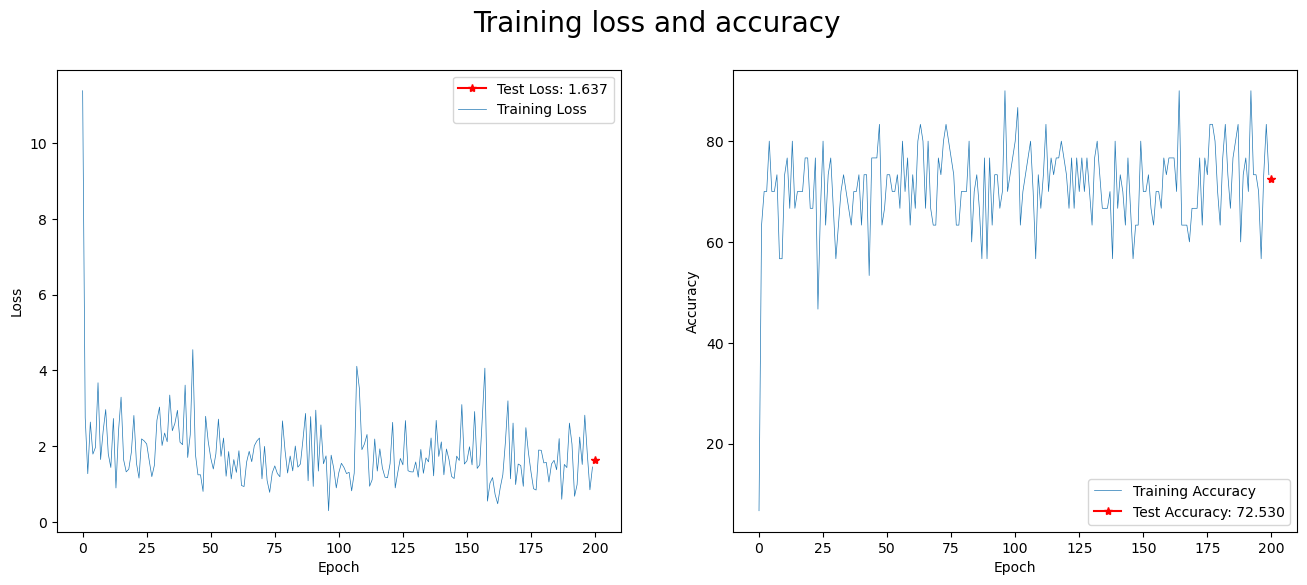

In [33]:
scalar = 2

leaky_200 = MLP(
    LinearLayer(D, hidden_units, parameter_variance),
    LeakyReLuLayer(scalar),
    
    LinearLayer(hidden_units, hidden_units, parameter_variance),
    LeakyReLuLayer(scalar),
    
    LinearLayer(hidden_units, C, parameter_variance),
    SoftMaxLayer(),

)
leaky_200.fit(data_x = X_train, data_y = Y_train, steps = gradient_steps,
         batch_size = batch_size, learning_rate = learning_rate)

leaky_200.predict(data_x = X_test, data_y = Y_test)
leaky_200.plot()

Unexpectedly, we see an increase in performance every time we increase our scalar, up to 72.53%! This is even better than our previous best with 2 hidden and regular ReLU.

### Tanh

The hyperbolic tangent function is also a candidate for common activation functions. However, as it is a saturating activation function, we suspect it to perform worse than the other candidates.

In [34]:
class TanhLayer(NeuralNetLayer):

    def forward(self, x):
        self.gradient = 1 - np.tanh(x)**2
        return np.tanh(x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

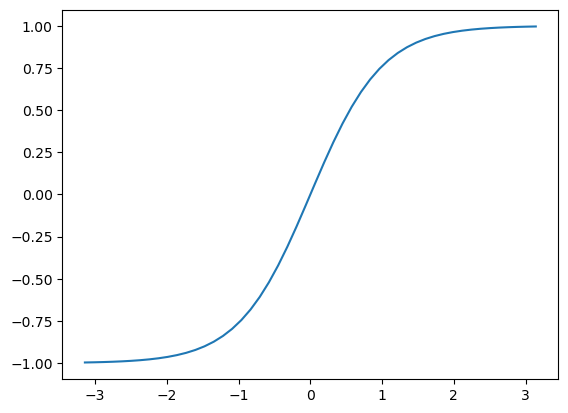

In [35]:
layer = TanhLayer()
x = np.linspace(-np.pi,np.pi)
y = layer.forward(x)
plt.plot(x, y)
plt.show()

100%|██████████| 2000/2000 [00:37<00:00, 52.86it/s]


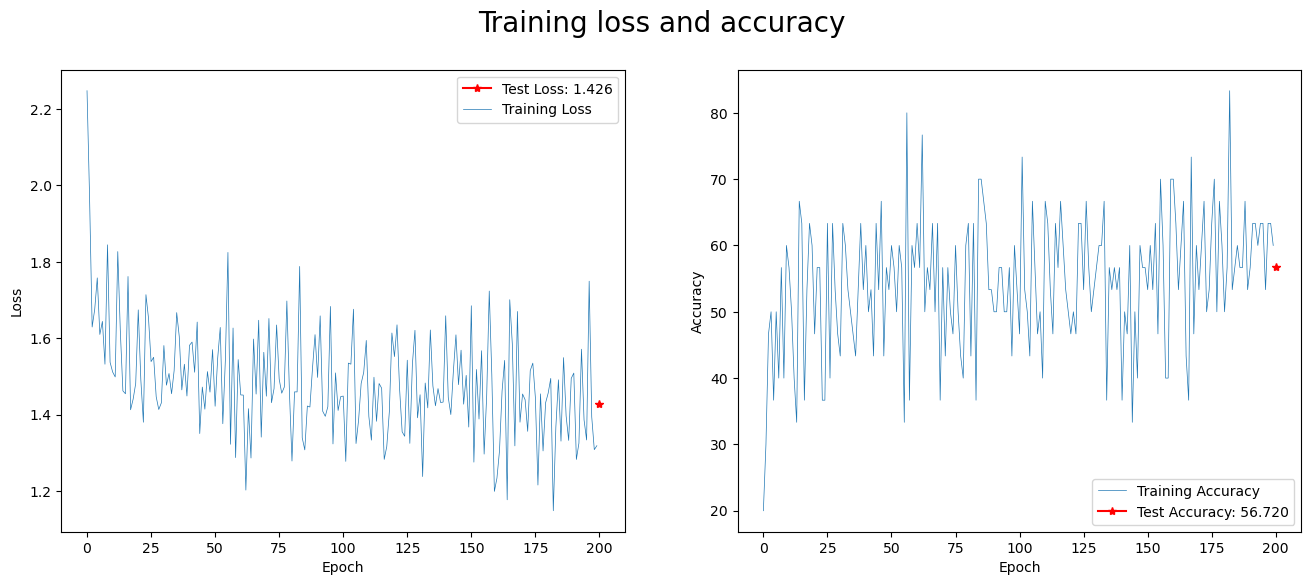

In [36]:
tanh_two_hidden = MLP(
    LinearLayer(D, hidden_units, parameter_variance),
    TanhLayer(),
    
    LinearLayer(hidden_units, hidden_units, parameter_variance),
    TanhLayer(),
    
    LinearLayer(hidden_units, C, parameter_variance),
    SoftMaxLayer(),

)
tanh_two_hidden.fit(data_x = X_train, data_y = Y_train, steps = gradient_steps,
         batch_size = batch_size, learning_rate = learning_rate)

tanh_two_hidden.predict(data_x = X_test, data_y = Y_test)
tanh_two_hidden.plot()

Our hypothesis turned out to be true: tanh performed considerably worse compared to LeakyReLu. We think this is because it is a saturating activation function.

### Conclusion on Activation Functions

Since saturating activation functions may cause the gradient to vanish too quickly, we tend to prefer non-saturating ones. We suspect this is why we see a lower accuracy for tanh and predict this decrease in accuracy could increase as more data is involved or more epochs are allowed.

Further, we see an increased accuracy using LeakyReLu. We suspect this might be because more information is used in calculating the activation: the negative part is still taken into consideration, whereas regular ReLu simply ignores the tail.

## 3. Effect of Batch Size on Accuracy


### batch_size = 2

100%|██████████| 2000/2000 [00:03<00:00, 531.67it/s]


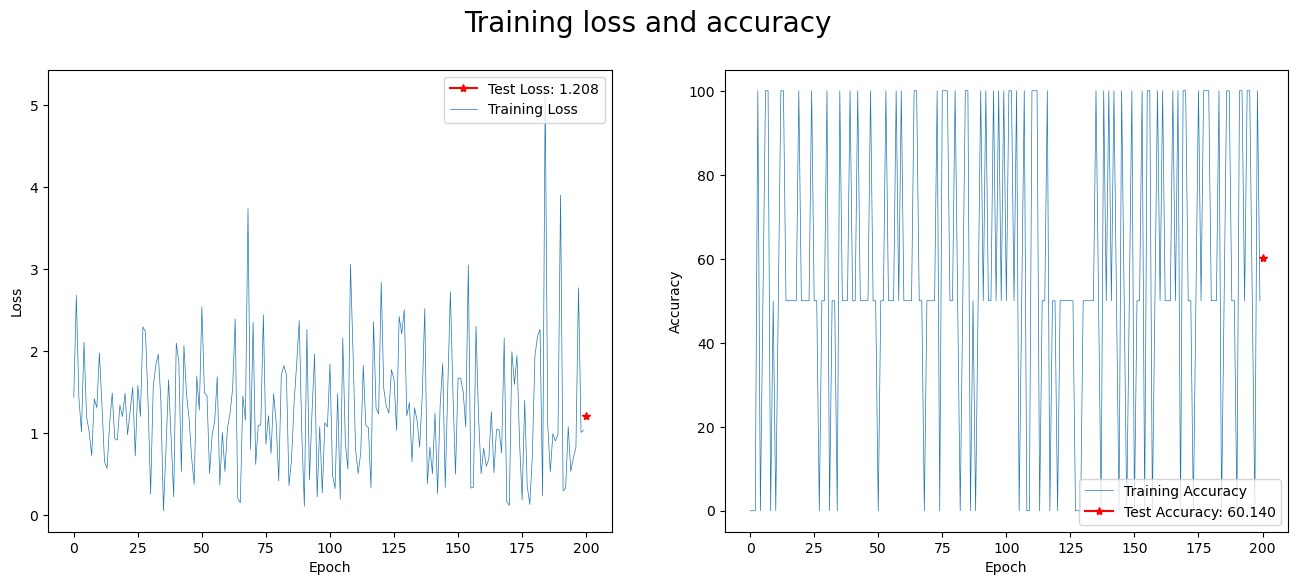

In [37]:
tmp_batch_size = 2

batch2 = MLP(
    LinearLayer(D, hidden_units, parameter_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, hidden_units, parameter_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, C, parameter_variance),
    SoftMaxLayer(),

)
batch2.fit(data_x = X_train, data_y = Y_train, steps = gradient_steps,
         batch_size = tmp_batch_size, learning_rate = learning_rate)

batch2.predict(data_x = X_test, data_y = Y_test)
batch2.plot()

### batch_size = 5

100%|██████████| 2000/2000 [00:07<00:00, 271.90it/s]


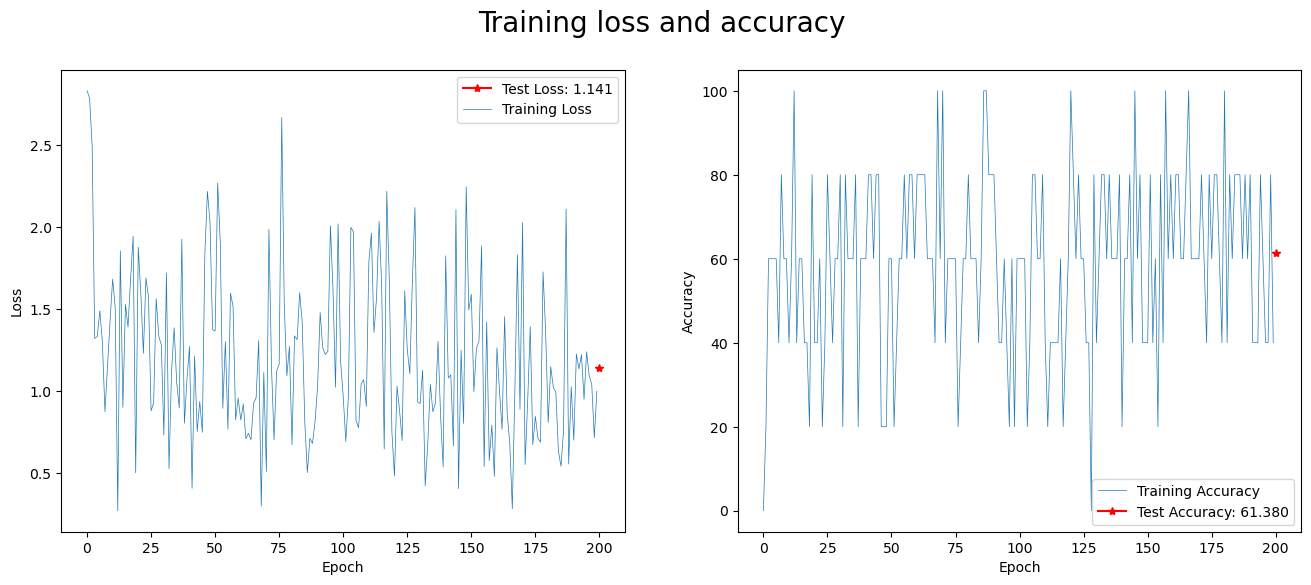

In [38]:
tmp_batch_size = 5

batch5 = MLP(
    LinearLayer(D, hidden_units, parameter_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, hidden_units, parameter_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, C, parameter_variance),
    SoftMaxLayer(),

)
batch5.fit(data_x = X_train, data_y = Y_train, steps = gradient_steps,
         batch_size = tmp_batch_size, learning_rate = learning_rate)

batch5.predict(data_x = X_test, data_y = Y_test)
batch5.plot()

### batch_size = 10

100%|██████████| 2000/2000 [00:13<00:00, 148.82it/s]


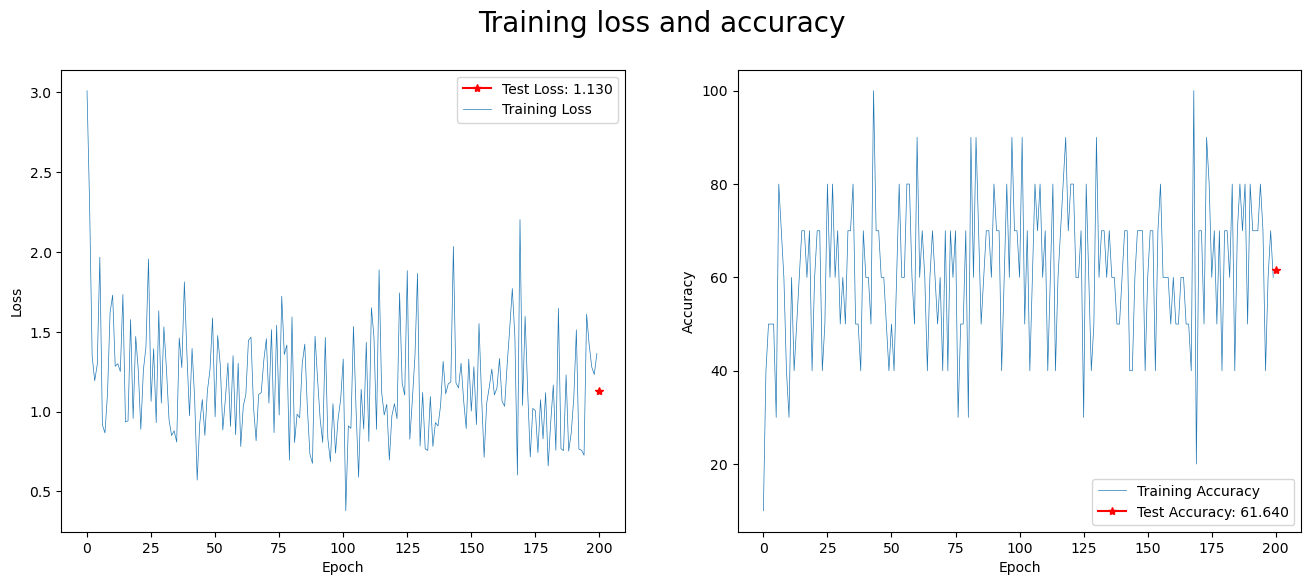

In [39]:
tmp_batch_size = 10

batch10 = MLP(
    LinearLayer(D, hidden_units, parameter_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, hidden_units, parameter_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, C, parameter_variance),
    SoftMaxLayer(),

)
batch10.fit(data_x = X_train, data_y = Y_train, steps = gradient_steps,
         batch_size = tmp_batch_size, learning_rate = learning_rate)

batch10.predict(data_x = X_test, data_y = Y_test)
batch10.plot()

### batch_size = 20

100%|██████████| 2000/2000 [00:25<00:00, 77.25it/s]


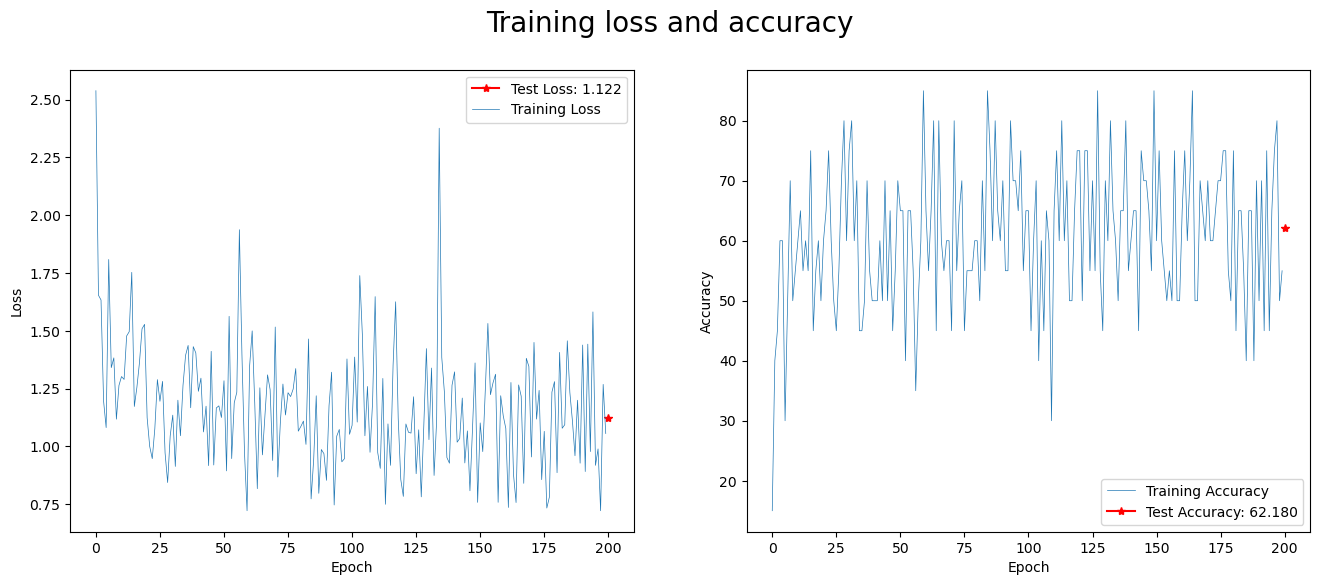

In [40]:
tmp_batch_size = 20

batch20 = MLP(
    LinearLayer(D, hidden_units, parameter_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, hidden_units, parameter_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, C, parameter_variance),
    SoftMaxLayer(),

)
batch20.fit(data_x = X_train, data_y = Y_train, steps = gradient_steps,
         batch_size = tmp_batch_size, learning_rate = learning_rate)

batch20.predict(data_x = X_test, data_y = Y_test)
batch20.plot()

### batch_size = 30

100%|██████████| 2000/2000 [00:37<00:00, 53.60it/s]


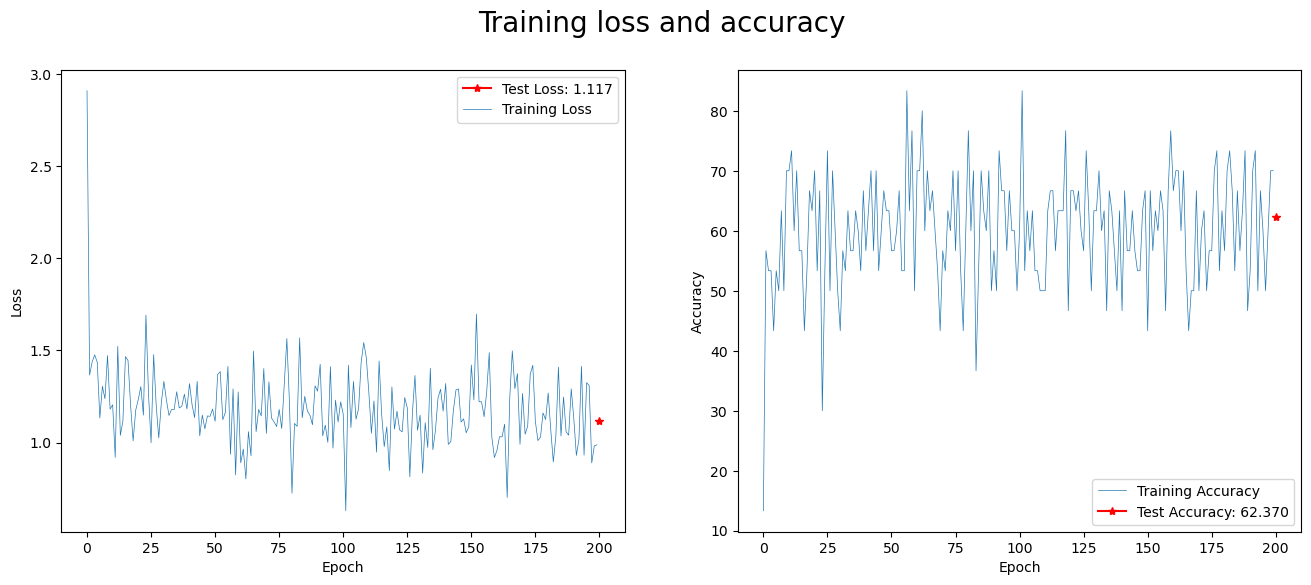

In [41]:
tmp_batch_size = 30

batch30 = MLP(
    LinearLayer(D, hidden_units, parameter_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, hidden_units, parameter_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, C, parameter_variance),
    SoftMaxLayer(),

)
batch30.fit(data_x = X_train, data_y = Y_train, steps = gradient_steps,
         batch_size = batch_size, learning_rate = learning_rate)

batch30.predict(data_x = X_test, data_y = Y_test)
batch30.plot()

This batch size is indeed the one that performs best, which is why we've chosen it as our default.

# 4. Effect of Normalization on Accuracy

## TODO: L2 Regularization

## Training on Raw Data

During pre-processing, we have centered and normalized the data by subtracting the mean and dividing by the standard deviation. In this stage we will examine the performance of our model with un-processed data.

100%|██████████| 2000/2000 [00:36<00:00, 54.09it/s]


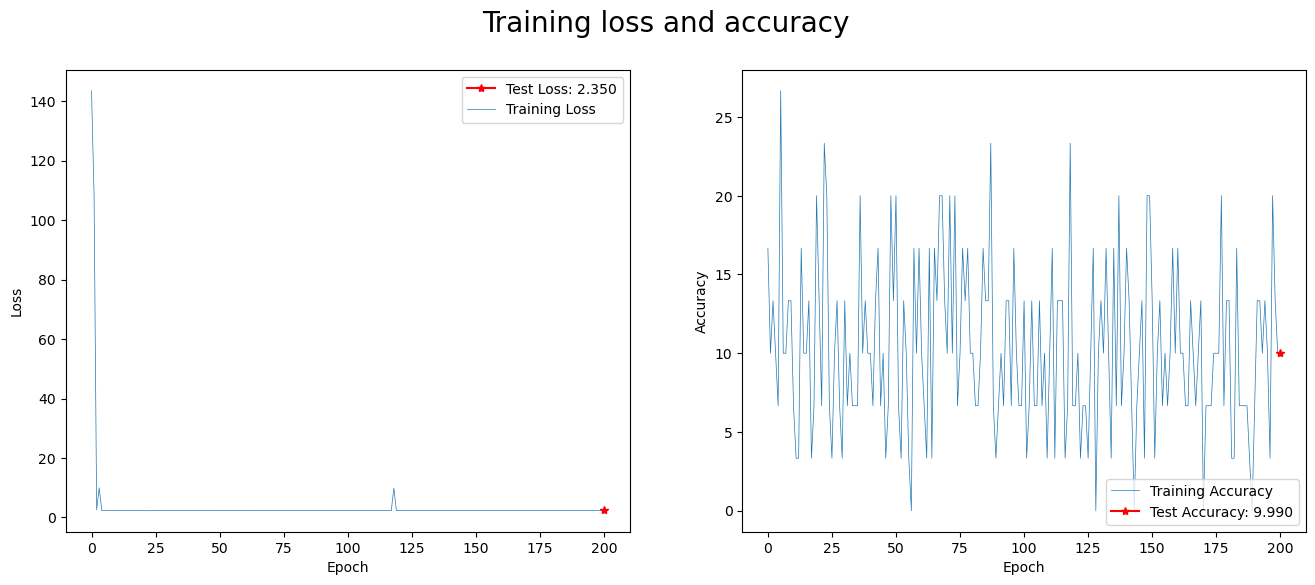

In [42]:
parameter_variance_unnormalized = 0.1

two_hidden_unnormalized = MLP(
    LinearLayer(D, hidden_units, parameter_variance_unnormalized),
    ReLuLayer(),
    
    LinearLayer(hidden_units, hidden_units, parameter_variance_unnormalized),
    ReLuLayer(),
    
    LinearLayer(hidden_units, C, parameter_variance_unnormalized),
    SoftMaxLayer(),

)
two_hidden_unnormalized.fit(data_x = X_train_raw, data_y = Y_train_raw, steps = gradient_steps,
         batch_size = batch_size, learning_rate = learning_rate)

# Remark: since we train on unnormalized images, we test on unnormalized images.
two_hidden_unnormalized.predict(data_x = X_test_raw, data_y = Y_test_raw)
two_hidden_unnormalized.plot()

We notice a decrease in accuracy, which justifies our pre-processing procedure. 

We suspect there is an interaction between parameter variance and sample variance. As with unnormalized data the variance will be an order of magnitude larger,  we need to account this by reducing the parameter variance by an order of magnitude, which balances out that of the input. Therefore we experiment with lower parameter variances.

100%|██████████| 2000/2000 [00:36<00:00, 54.97it/s]


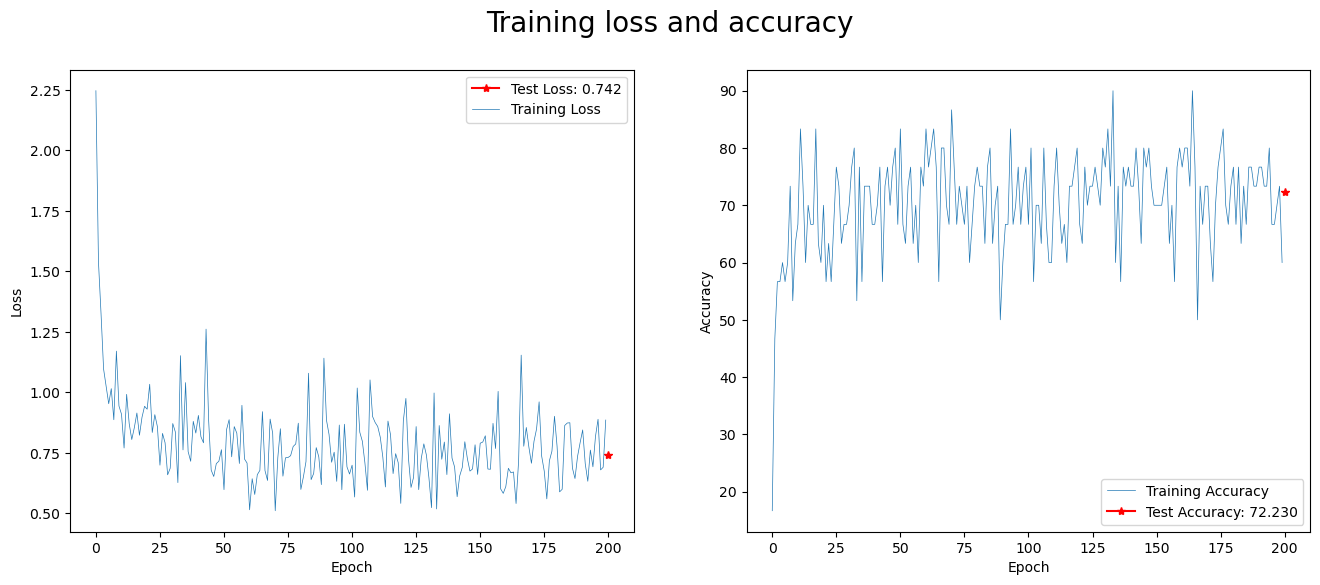

In [43]:
parameter_variance_unnormalized = 0.01

two_hidden_unnormalized = MLP(
    LinearLayer(D, hidden_units, parameter_variance_unnormalized),
    ReLuLayer(),
    
    LinearLayer(hidden_units, hidden_units, parameter_variance_unnormalized),
    ReLuLayer(),
    
    LinearLayer(hidden_units, C, parameter_variance_unnormalized),
    SoftMaxLayer(),

)
two_hidden_unnormalized.fit(data_x = X_train_raw, data_y = Y_train_raw, steps = gradient_steps,
         batch_size = batch_size, learning_rate = learning_rate)

# Remark: since we train on unnormalized images, we test on unnormalized images.
two_hidden_unnormalized.predict(data_x = X_test_raw, data_y = Y_test_raw)
two_hidden_unnormalized.plot()

An interesting result: we achieve our best result by using un-normalized data and a parameter variance of 0.01. Perhaps our model performs better with lower variance, we could've reduced our variance more during normalization.

## 4. Effect of Regularization on Accuracy

Recall that if $W$ is an $m \times n$ matrix: 
$$
W = 
\begin{bmatrix}
w_{1,1} & w_{1,2} & \cdots & w_{1,n} \\
w_{2,1} & w_{2,2} & \cdots & w_{2,n} \\
\vdots & \vdots & \ddots & \vdots \\
w_{m,1} & w_{m,2} & \cdots & w_{m,n} 
\end{bmatrix}
$$

then its $L^2$ norm is given by:

$$
\|W\|_2 = \sqrt{\sum_{i=1}^m \sum_{j=1}^n (w_{i,j})^2}
$$

The final experiment concerns $L^2$ regularization. By this, we mean that we work on our current loss function added with a positive scalar multiple of square of $L^2$ norm of exactly one of the weights instead of the original loss function. This causes the derivative of exactly one layer to be different than in the previous experiments. 

Fix the architecture to be double relu. Initialize the batch size and the weights/bias variance as before. We always train and test on standardized data sets.

We investigate how doing regularization on different layers affect our accuracy.

### No Regularization

See the results of section 1.

### Regularization on the very first layer.

In [44]:
regularization_scalar = 0.01

100%|██████████| 2000/2000 [00:37<00:00, 52.81it/s]


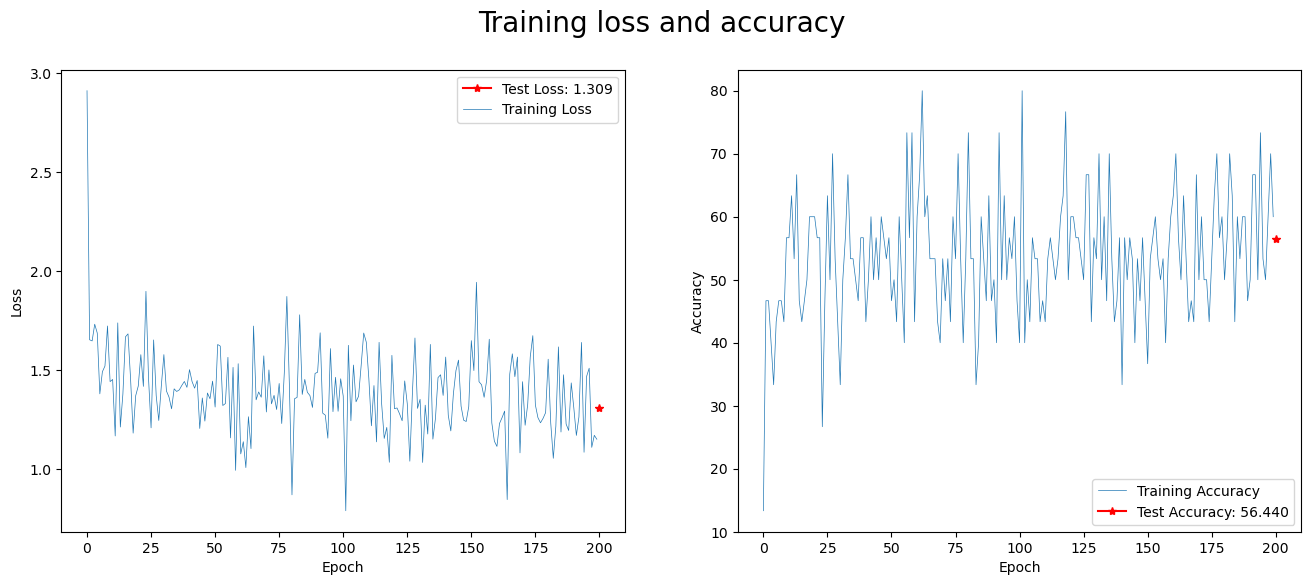

In [45]:
regularized_first_layer = LinearLayer(D, hidden_units, parameter_variance)
regularized_first_layer.regularization = regularization_scalar

first_regularization = MLP(
    regularized_first_layer,
    ReLuLayer(),
    
    LinearLayer(hidden_units, hidden_units, parameter_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, C, parameter_variance),
    SoftMaxLayer(),

)
first_regularization.fit(data_x = X_train, data_y = Y_train, steps = gradient_steps,
         batch_size = batch_size, learning_rate = learning_rate)

first_regularization.predict(data_x = X_test, data_y = Y_test)
first_regularization.plot()

### Regularization on the middle layer.

100%|██████████| 2000/2000 [00:36<00:00, 54.12it/s]


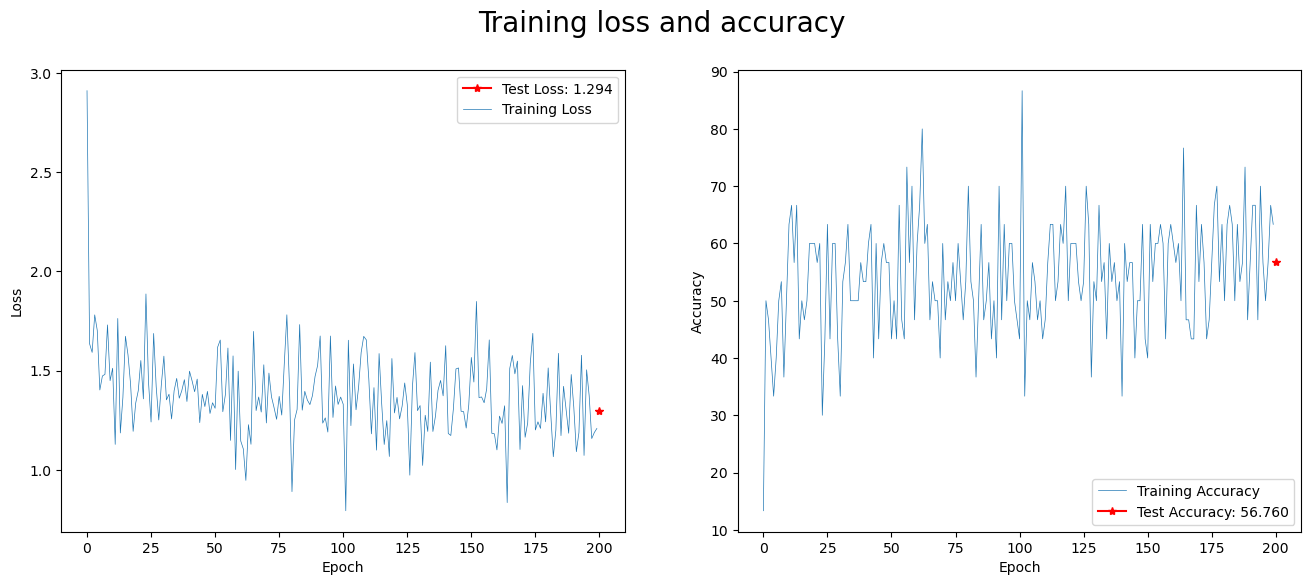

In [46]:
regularized_middle_layer = LinearLayer(hidden_units, hidden_units, parameter_variance)
regularized_middle_layer.regularization = regularization_scalar

middle_regularization = MLP(
    LinearLayer(D, hidden_units, parameter_variance),
    ReLuLayer(),
    
    regularized_middle_layer,
    ReLuLayer(),
    
    LinearLayer(hidden_units, C, parameter_variance),
    SoftMaxLayer(),

)
middle_regularization.fit(data_x = X_train, data_y = Y_train, steps = gradient_steps,
         batch_size = batch_size, learning_rate = learning_rate)

middle_regularization.predict(data_x = X_test, data_y = Y_test)
middle_regularization.plot()

## Regularization on the output layer.

100%|██████████| 2000/2000 [00:37<00:00, 53.08it/s]


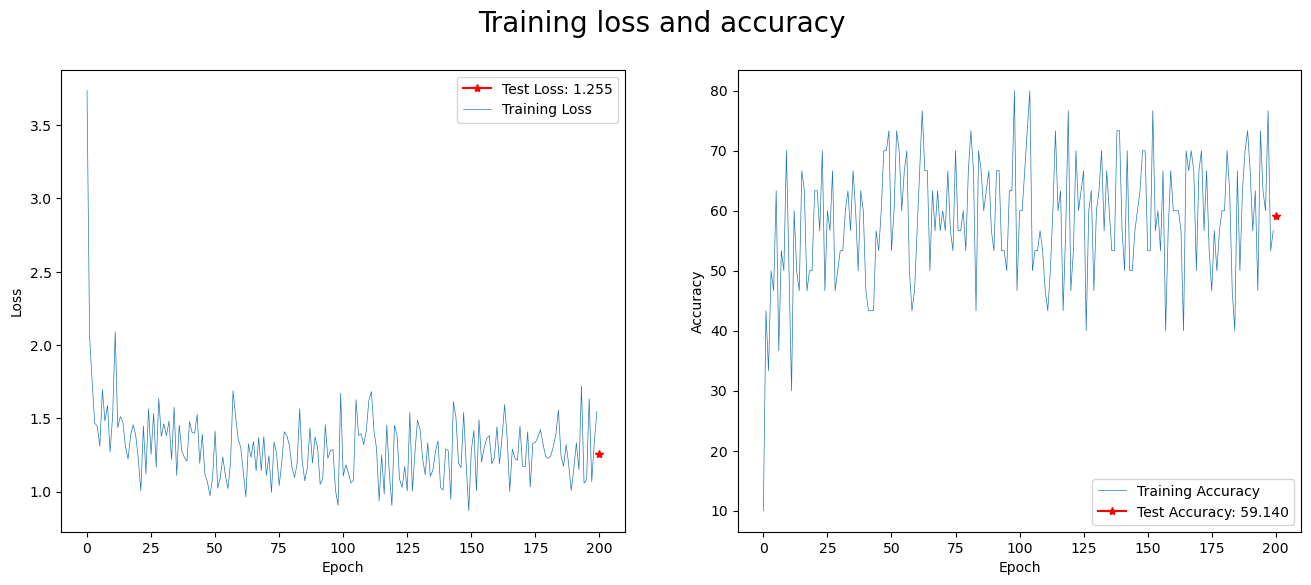

In [47]:
regularized_out_layer = LinearLayer(hidden_units, C, parameter_variance)
regularized_out_layer.regularization = regularization_scalar

out_regularization = MLP(
    LinearLayer(D, hidden_units, parameter_variance),
    ReLuLayer(),
    
    LinearLayer(hidden_units, hidden_units, parameter_variance),
    ReLuLayer(),
    
    regularized_out_layer,
    SoftMaxLayer(),

)
out_regularization.fit(data_x = X_train, data_y = Y_train, steps = gradient_steps,
         batch_size = batch_size, learning_rate = learning_rate)

out_regularization.predict(data_x = X_test, data_y = Y_test)
out_regularization.plot()

The accuracies are all close to each other and are similar to the non-regularized case. This is totally expected because our weights for the non-regularized case is not that large anyways.

## 5. Find Best MLP Architecture

In this section we will attempt to compile everything we've discovered to come up with the best architecture we can come up with.

In previous sections we've discovered our model performs best with:
- Batch size = 30
- 2 hidden layers of 128 units
- Leaky ReLU layers with scalar 2
- Parameter variance of 0.1. Note that we saw 0.01 works best with raw data, so with processed data which is an order of magnitude lower than the raw data, we use 0.01.

In [49]:
best_parameter_variance = 0.1
best_leaky_scalar = 2

100%|██████████| 2000/2000 [00:40<00:00, 49.89it/s]


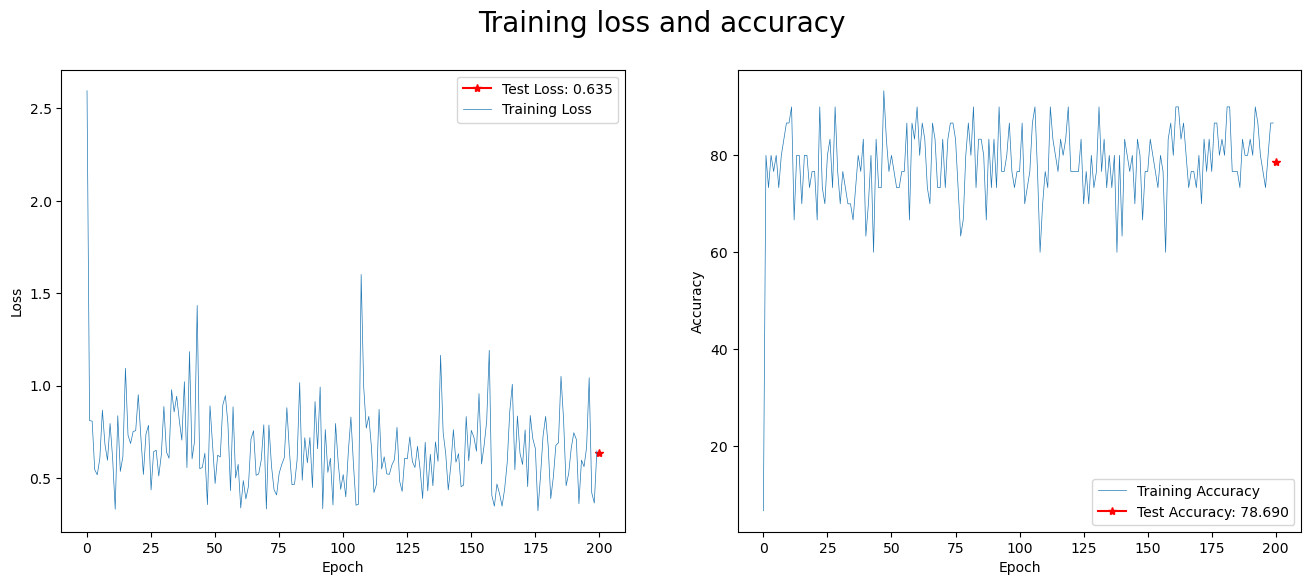

In [50]:
best_model = MLP(
    LinearLayer(D, hidden_units, parameter_variance_unnormalized),
    LeakyReLuLayer(best_leaky_scalar),
    
    LinearLayer(hidden_units, hidden_units, best_parameter_variance),
    LeakyReLuLayer(best_leaky_scalar),
    
    LinearLayer(hidden_units, C, best_parameter_variance),
    SoftMaxLayer(),

)
best_model.fit(data_x = X_train, data_y = Y_train, steps = gradient_steps,
         batch_size = batch_size, learning_rate = learning_rate)

# Remark: since we train on unnormalized images, we test on unnormalized images.
best_model.predict(data_x = X_test, data_y = Y_test)
best_model.plot()

## Implementing LeNet with PyTorch

For this section we will implement, with the help of PyTorch, one of the pioneering models in image recognition technology: LeNet.

In [51]:
from torch.autograd import Variable
from torch.nn import Flatten, Linear, BatchNorm2d, ReLU, CrossEntropyLoss, Conv2d, AvgPool2d, Module, Softmax
from torch.optim import Adam

!pip install torchsummary --quiet
from torchsummary import summary

from IPython.utils import io

In [52]:
torch.manual_seed(42) # Reproducability

In [53]:
X_train_torch = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_train_torch  = torch.from_numpy(X_train_torch)

X_test_torch = X_test.reshape(X_test.shape[0], 1, 28, 28)
X_test_torch  = torch.from_numpy(X_test_torch)

Y_train_torch = Y_train.astype(int);
Y_train_torch = torch.from_numpy(Y_train)

Y_test_torch = Y_test.astype(int);
Y_test_torch = torch.from_numpy(Y_test)

X_train_torch.shape, X_test_torch.shape, Y_train_torch.shape, Y_test_torch.shape

(torch.Size([60000, 1, 28, 28]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000]))

Our implementation differs slightly from the original LeNet, in that it uses batch normalization after convolution and that it uses the non-saturating ReLU instead of tanh.

In [54]:
class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.C1 = Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.batchnorm1 = BatchNorm2d(6)
        
        self.C2 = Conv2d(6, 16, kernel_size = 5, stride = 1, padding = 0)
        self.batchnorm2 = BatchNorm2d(16)
        
        self.C3 = Conv2d(16, 120, kernel_size = 5, stride = 1, padding = 0)
        self.batchnorm3 = BatchNorm2d(120)
        
        self.linear1 = Linear(120, 84)
        self.linear2 = Linear(84, 10)
        
        self.relu = ReLU()
        self.avgpool = AvgPool2d(kernel_size = 2, stride = 2)
        self.flatten = Flatten(start_dim=1)
        
    def forward(self, x):
        with io.capture_output() as captured: # needed for output suppression
            # C1
            x = self.C1(x)
            x = self.batchnorm1(x)
            x = self.relu(x)
            x = self.avgpool(x)

            # C2
            x = self.C2(x)
            x = self.batchnorm2(x)
            x = self.relu(x)
            x = self.avgpool(x)
            
            # C3
            x = self.C3(x)
            x = self.batchnorm3(x)
            x = self.relu(x)

            # Linear
            x = self.flatten(x)
            x = self.linear1(x)
            x = self.relu(x)
            x = self.linear2(x)
            return x

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LeNet().to(device)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()
    
print(model)
summary(model, (1,28,28))

LeNet(
  (C1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (C2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (C3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm3): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=120, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
       BatchNorm2d-2            [-1, 6, 28, 28]              12
       

In [56]:
def get_correct(y_hat, y):
    return y_hat.argmax(1).eq(y).sum().item()

def train(data_x, data_y, epochs, model, optimizer):
    model.train()
    train_losses = []
    train_accs = []
    tr_loss = 0
    
    data_x, data_y = Variable(data_x.float().to(device)), Variable(data_y.to(device))
        
    for epoch in range(epochs):
        optimizer.zero_grad()
        output_train = model(data_x)

        loss_train = criterion(output_train, data_y)
        train_losses.append(loss_train)
        
        loss_train.backward()
        optimizer.step()
        
        num_correct = get_correct(output_train, data_y)
        acc_train = (num_correct / len(data_y)) * 100
        train_accs.append(acc_train)

        
        tr_loss = loss_train.item()
        print(f'Epoch : {epoch + 1}, loss: {loss_train}, acc: {acc_train}')
        
    return train_losses, train_accs

# To be called on a trained model
def test(data_x, data_y, model):
    data_x, data_y = Variable(data_x.float().to(device)), Variable(data_y.to(device))
    output_test = model(data_x)
    
    loss_test = criterion(output_test, data_y)
            
    num_correct = get_correct(output_test, data_y)
    acc_test = (num_correct / len(data_y)) * 100
    
    return loss_test, acc_test
    

In [57]:
n_epochs = 25

train_losses, train_accs = train(X_train_torch, Y_train_torch, n_epochs, model, optimizer)
test_loss, test_acc = test(X_test_torch, Y_test_torch, model)
    
print()
print(f"Model trained for {n_epochs} epochs")
print(f"Minimum training loss: {train_losses[-1]:.3f}")
print(f"Test loss: {test_loss:.3f}")

print(f"Maxiumum training accuracy: {train_accs[-1]:.3f}")
print(f"Test accuracy: {test_acc:.3f}")

RuntimeError: expected scalar type Long but found Byte

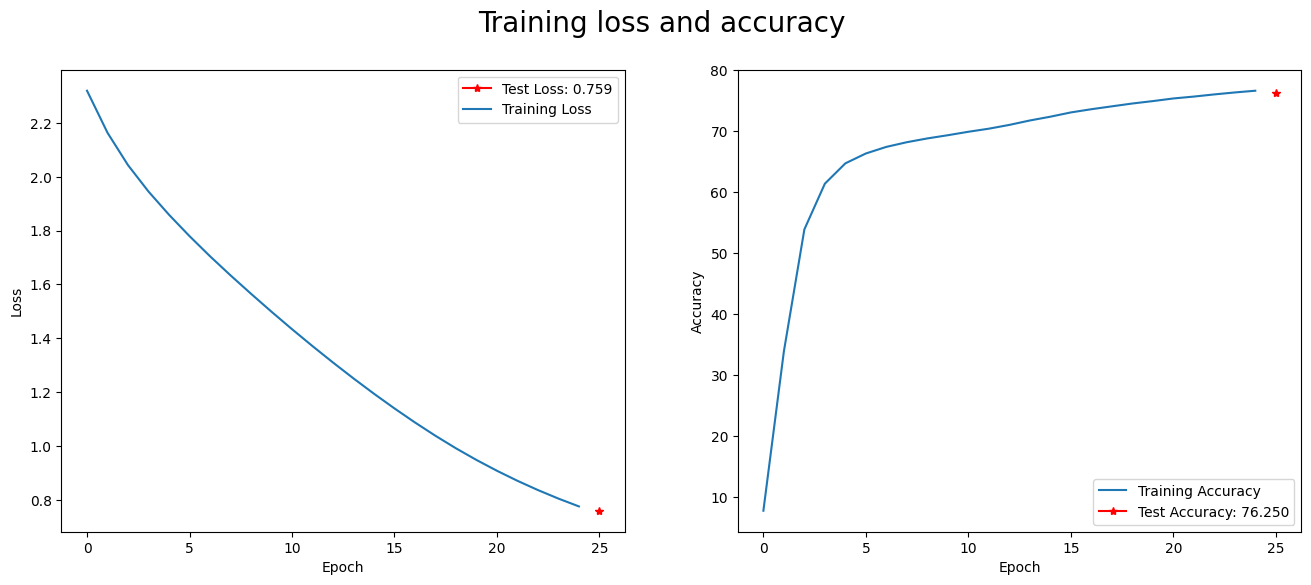

In [ ]:
fig = plt.figure(figsize=(16,6))
rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
fig.suptitle("Training loss and accuracy", fontsize=20)
plt.plot(n_epochs, float(test_loss), color='red', marker='*', label=f"Test Loss: {test_loss:.3f}")
plt.plot([float(loss) for loss in train_losses], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

fig.add_subplot(rows, columns, 2)
plt.plot([float(acc) for acc in train_accs], label="Training Accuracy")
plt.plot(n_epochs, float(test_acc), color='red', marker='*', label=f"Test Accuracy: {test_acc:.3f}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.show()

We see our model performs slightly better than the "updated" version of LeNet, although with more epochs LeNet might outperform.

## TODO: Creativity: Effect of Width

## TODO: Creativity: Effect of sample size 10^k , k ∈ {0, 1, 2, 3, 4} images

## TODO: Creativity: Implement Convolution & Pooling Layers